# Ensemble Learning Comparison Notebook

This notebook demonstrates different ensemble learning methods on a real dataset (Breast Cancer). It includes:

- Data loading and preprocessing
- Base models (Logistic Regression, Decision Tree, KNN)
- Ensemble methods: Voting (hard & soft), Weighted Averaging, Bagging, Random Forest, AdaBoost, Gradient Boosting (sklearn), XGBoost, LightGBM, CatBoost
- Evaluation and comparison (accuracy, ROC AUC)

> **Notes:** If you don't have `xgboost`, `lightgbm`, or `catboost` installed, the notebook provides pip install commands. Run the installation cell first if needed.


In [1]:

# If you need to install extra libraries, uncomment and run the following.
# !pip install xgboost lightgbm catboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

# Try imports for external boosters; notebook will still run if they're not installed, but those cells will error until installed.
try:
    import xgboost as xgb
except Exception as e:
    xgb = None
try:
    import lightgbm as lgb
except Exception as e:
    lgb = None
try:
    from catboost import CatBoostClassifier
except Exception as e:
    CatBoostClassifier = None

print('xgboost available:', xgb is not None)
print('lightgbm available:', lgb is not None)
print('catboost available:', CatBoostClassifier is not None)


xgboost available: True
lightgbm available: True
catboost available: False


In [4]:

# Load dataset (Breast Cancer) -- a real, well-known binary classification dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
print('Features shape:', X.shape)
print('Classes:', np.unique(y))
X.head()


Features shape: (569, 30)
Classes: [0 1]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:

# Split and create a simple pipeline for estimators that need scaling
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# to prevent data leakage, split the data first then preprocess
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:

# Base learners
lr = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

base_estimators = [('lr', lr), ('dt', dt), ('knn', knn)]


In [7]:

# Voting classifiers
voting_hard = VotingClassifier(estimators=base_estimators, voting='hard')
voting_soft = VotingClassifier(estimators=base_estimators, voting='soft')  # soft requires predict_proba from all estimators

for name, clf in [('Voting (hard)', voting_hard), ('Voting (soft)', voting_soft)]:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f'{name} accuracy:', accuracy_score(y_test, preds))


Voting (hard) accuracy: 0.9824561403508771
Voting (soft) accuracy: 0.956140350877193


In [11]:

# Weighted Averaging (manual): combine predicted probabilities with weights then threshold
weights = {'lr': 0.5, 'dt': 0.2, 'knn': 0.3}
# Fit base models
for name, model in base_estimators:
    model.fit(X_train, y_train)

# Get weighted average probabilities
probs = np.zeros((X_test.shape[0], 2))
for name, model in base_estimators:
    p = model.predict_proba(X_test)
    probs += weights[name] * p

weighted_preds = np.argmax(probs, axis=1)
print('Weighted averaging accuracy:', accuracy_score(y_test, weighted_preds))


Weighted averaging accuracy: 0.9824561403508771


In [13]:
# Bagging (with decision trees) and Random Forest
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

for name, clf in [('Bagging', bagging), ('Random Forest', rf)]:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f'{name} accuracy:', accuracy_score(y_test, preds))

Bagging accuracy: 0.9385964912280702
Random Forest accuracy: 0.956140350877193


In [14]:

# Boosting methods
adb = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
gbm = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)

for name, clf in [('AdaBoost', adb), ('GradientBoosting (sklearn)', gbm)]:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f'{name} accuracy:', accuracy_score(y_test, preds))


AdaBoost accuracy: 0.956140350877193
GradientBoosting (sklearn) accuracy: 0.956140350877193


In [15]:

# XGBoost (if available)
if xgb is not None:
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
    xgb_clf.fit(X_train, y_train)
    print('XGBoost accuracy:', accuracy_score(y_test, xgb_clf.predict(X_test)))
else:
    print('XGBoost not installed. To enable, run: pip install xgboost')

# LightGBM (if available)
if lgb is not None:
    lgb_clf = lgb.LGBMClassifier(random_state=RANDOM_STATE)
    lgb_clf.fit(X_train, y_train)
    print('LightGBM accuracy:', accuracy_score(y_test, lgb_clf.predict(X_test)))
else:
    print('LightGBM not installed. To enable, run: pip install lightgbm')

# CatBoost (if available)
if CatBoostClassifier is not None:
    cat_clf = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
    cat_clf.fit(X_train, y_train)
    print('CatBoost accuracy:', accuracy_score(y_test, cat_clf.predict(X_test)))
else:
    print('CatBoost not installed. To enable, run: pip install catboost')


XGBoost accuracy: 0.956140350877193
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 285, number of negative: 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [16]:

# Cross-validated comparison for a set of classifiers
from sklearn.model_selection import cross_val_score

clfs = {
    'LogisticRegression': lr,
    'DecisionTree': dt,
    'KNN': knn,
    'Voting_hard': voting_hard,
    'Voting_soft': voting_soft,
    'Bagging': bagging,
    'RandomForest': rf,
    'AdaBoost': adb,
    'GradientBoosting': gbm
}

# Add boosters if available
if xgb is not None:
    clfs['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
if lgb is not None:
    clfs['LightGBM'] = lgb.LGBMClassifier(random_state=RANDOM_STATE)
if CatBoostClassifier is not None:
    clfs['CatBoost'] = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model in clfs.items():
    try:
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append({'model': name, 'mean_accuracy': float(np.mean(scores)), 'std': float(np.std(scores))})
        print(f'{name}: mean acc = {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    except Exception as e:
        print('Error evaluating', name, ':', e)

results_df = pd.DataFrame(results).sort_values('mean_accuracy', ascending=False).reset_index(drop=True)
results_df


LogisticRegression: mean acc = 0.9754 +/- 0.0140
DecisionTree: mean acc = 0.9104 +/- 0.0279
KNN: mean acc = 0.9631 +/- 0.0179
Voting_hard: mean acc = 0.9649 +/- 0.0200
Voting_soft: mean acc = 0.9561 +/- 0.0157
Bagging: mean acc = 0.9578 +/- 0.0140
RandomForest: mean acc = 0.9561 +/- 0.0123
AdaBoost: mean acc = 0.9666 +/- 0.0179
GradientBoosting: mean acc = 0.9491 +/- 0.0237
XGBoost: mean acc = 0.9526 +/- 0.0089
LightGBM: mean acc = 0.9666 +/- 0.0129


,model,mean_accuracy,std
0,LogisticRegression,0.975423,0.014018
1,LightGBM,0.966636,0.012854
2,AdaBoost,0.966620,0.017873
3,Voting_hard,0.964850,0.020003
4,KNN,0.963096,0.017886
5,Bagging,0.957833,0.014005
6,RandomForest,0.956094,0.012340
7,Voting_soft,0.956078,0.015657
8,XGBoost,0.952554,0.008916
9,GradientBoosting,0.949076,0.023750


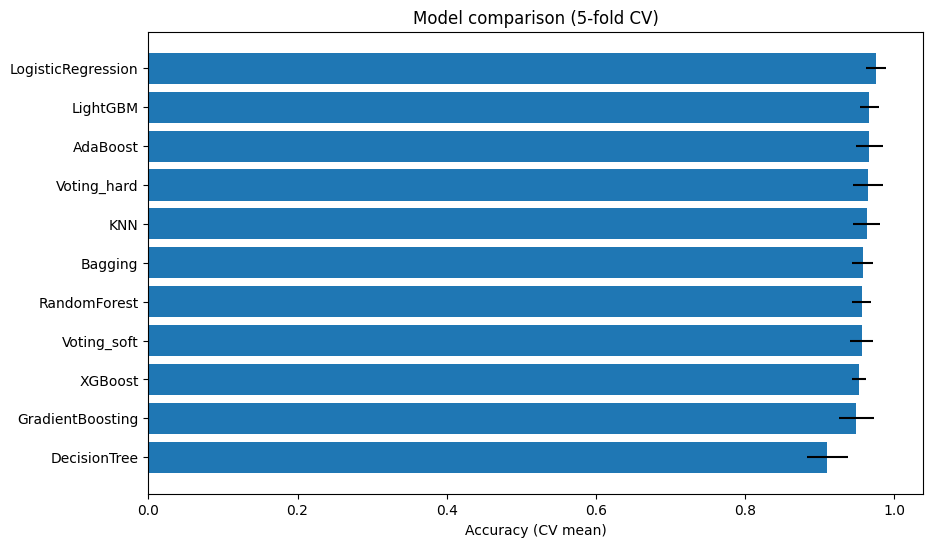

In [17]:

# Plot comparison
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(results_df['model'], results_df['mean_accuracy'], xerr=results_df['std'])
ax.set_xlabel('Accuracy (CV mean)')
ax.set_title('Model comparison (5-fold CV)')
plt.gca().invert_yaxis()
plt.show()



## Explanations and takeaways

- **Voting (hard/soft):** Combine multiple different models by majority vote (hard) or by averaging predicted probabilities (soft). Soft voting often performs better when models output well-calibrated probabilities.

- **Weighted Averaging:** Like soft voting but with manual weights for each model's predicted probabilities. Useful when you trust some models more.

- **Bagging:** Builds multiple bootstrap samples and aggregates predictions (reduces variance). Decision trees are common base estimators.

- **Random Forest:** Bagging + random feature selection for each split. Great off-the-shelf ensemble with low tuning needs.

- **AdaBoost:** Sequential boosting that focuses on previously misclassified samples by reweighting them. Can reduce bias.

- **Gradient Boosting (sklearn / XGBoost / LightGBM / CatBoost):** Stage-wise boosting optimizing a differentiable loss. XGBoost/LightGBM/CatBoost are optimized implementations with speed and additional features.

**Takeaway:** Ensembles typically improve stability and accuracy over single models, especially when base learners are diverse. However, they can be slower and less interpretable.

---

### Next steps (suggested)
- Hyperparameter tuning (GridSearchCV / RandomizedSearchCV) for top models
- Evaluate other metrics: precision, recall, F1, PR AUC, calibration
- Try stacking (meta-model) to learn optimal combination weights
